In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import gc

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
Dir = '/Users/ggq/Downloads/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/'
tourney_result = pd.read_csv(
    Dir+'MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv(
    Dir+'MNCAATourneySeeds.csv')
tourney_GameDetail = pd.read_csv(Dir+'MNCAATourneyDetailedResults.csv')
Regular_SeasonDetail = pd.read_csv(Dir+'MRegularSeasonDetailedResults.csv')

In [3]:
Regular_SeasonDetail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,132,1153,69,1222,57,N,0,22,50,...,33,11,18,17,16,8,7,2,4,19
87500,2019,132,1209,73,1426,64,N,0,20,50,...,33,11,17,13,28,12,14,5,2,24
87501,2019,132,1277,65,1276,60,N,0,22,55,...,25,10,12,3,26,17,6,5,5,11
87502,2019,132,1387,55,1382,53,N,0,22,59,...,19,8,10,13,30,9,11,2,7,16


In [4]:
Massey = pd.read_csv(
    Dir+'MMasseyOrdinals.csv')
Massey

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
3820914,2019,133,ZAM,1462,70
3820915,2019,133,ZAM,1463,87
3820916,2019,133,ZAM,1464,242
3820917,2019,133,ZAM,1465,198


In [5]:
Massey[(Massey['RankingDayNum']==133) & (Massey['Season']==2011)]

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
1471488,2011,133,AP,1112,17
1471489,2011,133,AP,1140,10
1471490,2011,133,AP,1163,9
1471491,2011,133,AP,1181,3
1471492,2011,133,AP,1196,15
...,...,...,...,...,...
1488463,2011,133,WOL,1460,117
1488464,2011,133,WOL,1461,257
1488465,2011,133,WOL,1462,31
1488466,2011,133,WOL,1463,155


In [6]:
#Massey这张表所有的ranking day
a= Massey['RankingDayNum']
a = a.unique()
a.sort()
print(a)
for y in Massey['Season'].unique():
    b= Massey[Massey['Season']==y]['SystemName']
    b = b.unique()
    print(b)

[  0   1   6   7   8   9  11  12  13  14  15  16  20  21  22  23  27  28
  29  30  34  35  36  37  41  42  43  44  48  49  50  51  52  53  54  55
  56  57  58  60  61  62  63  64  65  69  70  71  72  75  76  77  78  79
  82  83  84  85  86  89  90  91  92  93  95  96  97  98  99 100 103 104
 105 106 107 111 112 113 114 117 118 119 120 121 124 125 126 127 128 133]
['SEL' 'AP' 'BIH' 'DUN' 'ENT' 'GRN' 'IMS' 'MAS' 'MKV' 'MOR' 'POM' 'RPI'
 'SAG' 'SAU' 'SE' 'STR' 'USA' 'WLK' 'WOB' 'BOB' 'DWH' 'ERD' 'ECK' 'BRZ'
 'ARG' 'RTH' 'WOL' 'HOL' 'COL' 'DOL' 'GC' 'GRS' 'HER' 'TSR' 'MIC' 'WTE']
['AP' 'MAS' 'POM' 'SAG' 'USA' 'DWH' 'BD' 'BIH' 'ENT' 'WOB' 'HER' 'MGY'
 'RAG' 'WLK' 'DOL' 'GRS' 'SEL' 'GRN' 'HOL' 'MKV' 'MOR' 'RPI' 'SAU' 'ARG'
 'BOB' 'CNG' 'SIM' 'TSR' 'ECK' 'RTH' 'DES' 'JON' 'COL' 'LYN' 'WOL' 'NOR'
 'RM' 'REI']
['ACU' 'AP' 'ENT' 'MOR' 'POM' 'SAG' 'USA' 'TSR' 'BCM' 'SIM' 'HER' 'CMV'
 'BD' 'GRN' 'WLK' 'RAG' 'SAP' 'DC' 'KLK' 'MAS' 'SEL' 'DES' 'WIL' 'CNG'
 'COL' 'DOL' 'ROH' 'RPI' 'WOB' 'ARG' 'BOB' '

In [37]:
last_round = Massey[(Massey['RankingDayNum']==133)]
group = last_round.groupby(['Season','TeamID'])
num_agg = {'OrdinalRank':['min', 'mean', 'max','std']}
group_agg=group.agg(num_agg)
rank = group_agg.reset_index()
print(rank)

     Season TeamID OrdinalRank                            
                           min        mean  max        std
0      2003   1102          97  156.031250  198  17.102130
1      2003   1103         128  168.000000  194  12.559536
2      2003   1104          26   38.031250   60   6.794136
3      2003   1105         289  308.968750  315   5.877702
4      2003   1106         198  262.687500  305  21.178866
...     ...    ...         ...         ...  ...        ...
5828   2019   1462          34   67.281250  112  13.641055
5829   2019   1463          39   77.203125  106  13.881791
5830   2019   1464         228  273.312500  305  15.828320
5831   2019   1465         160  205.238095  293  22.936599
5832   2019   1466         260  303.111111  343  14.028900

[5833 rows x 6 columns]


In [45]:
rank['rank_min']=rank['OrdinalRank']['min']
rank['rank_max']=rank['OrdinalRank']['max']
rank['rank_mean']=rank['OrdinalRank']['mean']
rank['rank_std']=rank['OrdinalRank']['std']

In [47]:
rank.drop(['OrdinalRank'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [48]:
rank

,Season,TeamID,rank_min,rank_max,rank_mean,rank_std
,,,,,,
0,2003,1102,97,198,156.031250,17.102130
1,2003,1103,128,194,168.000000,12.559536
2,2003,1104,26,60,38.031250,6.794136
3,2003,1105,289,315,308.968750,5.877702
4,2003,1106,198,305,262.687500,21.178866
...,...,...,...,...,...,...
5828,2019,1462,34,112,67.281250,13.641055
5829,2019,1463,39,106,77.203125,13.881791
5830,2019,1464,228,305,273.312500,15.828320


In [7]:
#获得篮板 得分 命中率等球队基础数据
def build_team_stat(Regular_SeasonDetail):
    Regular_SeasonDetail = Regular_SeasonDetail.drop(['NumOT','WPF','LPF','WBlk','LBlk',\
                                                      'WAst','LAst','WStl','LStl'], axis=1)
    Regular_SeasonDetail_Wsum = Regular_SeasonDetail.groupby(['Season','WTeamID']).sum().reset_index()\
    .drop(['DayNum','LTeamID'],axis=1)
    Regular_Wsum_count = Regular_SeasonDetail.groupby(['Season','WTeamID']).count().reset_index()
    Regular_SeasonDetail_Lsum = Regular_SeasonDetail.groupby(['Season','LTeamID']).sum().reset_index()\
    .drop(['DayNum','WTeamID'],axis=1)
    Regular_Lsum_count = Regular_SeasonDetail.groupby(['Season','LTeamID']).count().reset_index()
    Regular_Wsum_count = Regular_Wsum_count.loc[:,['Season','WTeamID','DayNum']]
    Regular_Wsum_count = Regular_Wsum_count.rename(columns={'DayNum':'WCount'})
    Regular_Lsum_count = Regular_Lsum_count.loc[:,['Season','LTeamID','DayNum']]
    Regular_Lsum_count = Regular_Lsum_count.rename(columns={'DayNum':'LCount'})
    
    Regular_Combat_gain = pd.merge(Regular_Wsum_count, Regular_Lsum_count, 
                                   left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'], how='outer')
    Regular_Combat_gain['WCount'] = Regular_Combat_gain['WCount'].fillna(0)
    Regular_Combat_gain['LCount'] = Regular_Combat_gain['LCount'].fillna(0)
    Regular_Combat_gain['WTeamID'] = Regular_Combat_gain['WTeamID'].fillna(Regular_Combat_gain['LTeamID'])
    Regular_Combat_gain['LTeamID'] = Regular_Combat_gain['LTeamID'].fillna(Regular_Combat_gain['WTeamID'])
    Regular_Combat_gain['PW'] = list(map(lambda x,y: x/(x+y), 
                                         Regular_Combat_gain['WCount'], Regular_Combat_gain['LCount']))
    Regular_Combat_gain[['WTeamID','WCount','LTeamID','LCount']] = Regular_Combat_gain[[\
        'WTeamID','WCount','LTeamID','LCount']].astype('int')
    Regular_Combat_gain['GameCount'] = Regular_Combat_gain['LCount']+Regular_Combat_gain['WCount']
    Regular_Combat_gain = Regular_Combat_gain.drop(['LTeamID'], axis=1).rename(columns={'WTeamID':'TeamID'})
    
    Regular_Team_stat_W = pd.merge(Regular_Combat_gain, Regular_SeasonDetail_Wsum, 
                                   left_on=['Season', 'TeamID'], right_on=['Season', 'WTeamID'], how='left')
    Regular_Team_stat_L = pd.merge(Regular_Combat_gain, Regular_SeasonDetail_Lsum, 
                                   left_on=['Season', 'TeamID'], right_on=['Season', 'LTeamID'], how='left')
    Regular_Team_stat = combineW_L_stat(Regular_Team_stat_W, Regular_Team_stat_L)
    
    return Regular_Team_stat

def combineW_L_stat(Regular_Team_stat_W,Regular_Team_stat_L):
    Regular_Team_stat_W = Regular_Team_stat_W.fillna(0)
    Regular_Team_stat_L = Regular_Team_stat_L.fillna(0)
    Regular_Team_stat_W['WScore'] = (Regular_Team_stat_W['WScore'] \
        * Regular_Team_stat_W['PW'] + Regular_Team_stat_L['LScore'] \
        * (1 - Regular_Team_stat_W['PW']))/Regular_Team_stat_W['GameCount']
    Regular_Team_stat_W['LScore'] = (Regular_Team_stat_W['LScore'] \
        * Regular_Team_stat_W['PW'] + Regular_Team_stat_L['WScore'] \
        * (1 - Regular_Team_stat_W['PW']))/Regular_Team_stat_W['GameCount']
    Regular_Team_stat_W.rename(columns={'WScore':'Score', 'LScore':'OppoScore'}, inplace=True)
    
    Regular_Team_stat_W['TS'] = (Regular_Team_stat_W['PW']*(2*Regular_Team_stat_W['WFGM']\
        +Regular_Team_stat_W['WFTM']+3*Regular_Team_stat_W['WFGM3'])/\
        (2*(Regular_Team_stat_W['WFGA']+Regular_Team_stat_W['WFGA3'])+0.44*Regular_Team_stat_W['WFTA']+0.000000001)+\
        (1-Regular_Team_stat_W['PW'])*(2*Regular_Team_stat_L['LFGM']\
        +Regular_Team_stat_L['LFTM']+3*Regular_Team_stat_L['LFGM3'])/\
        (2*(Regular_Team_stat_L['LFGA']+Regular_Team_stat_L['LFGA3'])+0.44*Regular_Team_stat_L['LFTA']+0.000000001))
    
    Regular_Team_stat_W['OppoTS'] = (Regular_Team_stat_W['PW']*(2*Regular_Team_stat_W['LFGM']\
        +Regular_Team_stat_W['LFTM']+3*Regular_Team_stat_W['LFGM3'])/\
        (2*(Regular_Team_stat_W['LFGA']+Regular_Team_stat_W['LFGA3'])+0.44*Regular_Team_stat_W['LFTA']+0.000000001)+\
        (1-Regular_Team_stat_W['PW'])*(2*Regular_Team_stat_L['WFGM']\
        +Regular_Team_stat_L['WFTM']+3*Regular_Team_stat_L['WFGM3'])/\
        (2*(Regular_Team_stat_L['WFGA']+Regular_Team_stat_L['WFGA3'])+0.44*Regular_Team_stat_L['WFTA']+0.000000001))

        
    
    Regular_Team_stat_W['WOR'] = (Regular_Team_stat_W['WOR'] \
        * Regular_Team_stat_W['PW'] + Regular_Team_stat_L['LOR'] \
        * (1 - Regular_Team_stat_W['PW']))/Regular_Team_stat_W['GameCount']
    Regular_Team_stat_W['WDR'] = (Regular_Team_stat_W['WDR'] \
        * Regular_Team_stat_W['PW'] + Regular_Team_stat_L['LDR'] \
        * (1 - Regular_Team_stat_W['PW']))/Regular_Team_stat_W['GameCount']
    Regular_Team_stat_W['LOR'] = (Regular_Team_stat_W['LOR'] \
        * Regular_Team_stat_W['PW'] + Regular_Team_stat_L['WOR'] \
        * (1 - Regular_Team_stat_W['PW']))/Regular_Team_stat_W['GameCount']
    Regular_Team_stat_W['LDR'] = (Regular_Team_stat_W['LDR'] \
        * Regular_Team_stat_W['PW'] + Regular_Team_stat_L['WDR'] \
        * (1 - Regular_Team_stat_W['PW']))/Regular_Team_stat_W['GameCount']
    Regular_Team_stat_W.rename(columns={'WOR':'OR', 'WDR':'DR','LOR':'OppoOR','LDR':'OppoDR'}, inplace=True)
    Regular_Team_stat_W.drop(['WTeamID','WFGM','LFGM','WFGA','LFGA','WFGM3','LFGM3','WFGA3','LFGA3','WFTM',\
                              'LFTM','WFTA','LFTA','WTO','LTO'], axis=1, inplace=True)
    return Regular_Team_stat_W

In [8]:
pd.set_option('display.max_columns', 50)
Regular_Team_stat = build_team_stat(Regular_SeasonDetail)
Regular_Team_stat

,Season,TeamID,WCount,LCount,PW,GameCount,Score,OppoScore,OR,DR,OppoOR,OppoDR,TS,OppoTS
0,2003,1102,12,16,0.428571,28,28.505102,29.316327,2.153061,8.428571,4.841837,10.408163,0.563983,0.567573
1,2003,1103,13,14,0.481481,27,39.282579,39.123457,4.902606,9.949246,6.002743,11.068587,0.578472,0.572418
2,2003,1104,17,11,0.607143,28,36.938776,33.540816,7.091837,12.836735,5.741071,11.872449,0.500933,0.497357
3,2003,1105,7,19,0.269231,26,42.576923,47.761834,8.054734,13.678994,8.007396,16.352071,0.497939,0.544014
4,2003,1106,13,15,0.464286,28,31.809949,32.230867,6.158163,11.852041,5.684949,11.326531,0.496283,0.499011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2005,1366,0,28,0.000000,28,57.964286,81.214286,14.928571,22.500000,15.535714,28.214286,0.417531,0.539571
5830,2008,1312,0,29,0.000000,29,55.931034,77.000000,11.689655,22.655172,10.965517,26.586207,0.436675,0.578891
5831,2013,1212,0,28,0.000000,28,49.678571,76.357143,9.821429,21.392857,13.750000,24.607143,0.425039,0.539708
5832,2015,1212,0,27,0.000000,27,51.111111,73.777778,9.814815,21.814815,12.333333,23.925926,0.442368,0.527366


In [9]:
#加上球队seed特征
def get_seed(x):
    return int(x[1:3])

tourney_seed['Seed'] = tourney_seed['Seed'].map(lambda x: get_seed(x))
Regular_Team_stat_seed = pd.merge(Regular_Team_stat,tourney_seed,left_on=['Season','TeamID'],\
                                  right_on=['Season','TeamID'],how='left')
Regular_Team_stat_seed

,Season,TeamID,WCount,LCount,PW,GameCount,Score,OppoScore,OR,DR,OppoOR,OppoDR,TS,OppoTS,Seed
0,2003,1102,12,16,0.428571,28,28.505102,29.316327,2.153061,8.428571,4.841837,10.408163,0.563983,0.567573,NaN
1,2003,1103,13,14,0.481481,27,39.282579,39.123457,4.902606,9.949246,6.002743,11.068587,0.578472,0.572418,NaN
2,2003,1104,17,11,0.607143,28,36.938776,33.540816,7.091837,12.836735,5.741071,11.872449,0.500933,0.497357,10.0
3,2003,1105,7,19,0.269231,26,42.576923,47.761834,8.054734,13.678994,8.007396,16.352071,0.497939,0.544014,NaN
4,2003,1106,13,15,0.464286,28,31.809949,32.230867,6.158163,11.852041,5.684949,11.326531,0.496283,0.499011,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2005,1366,0,28,0.000000,28,57.964286,81.214286,14.928571,22.500000,15.535714,28.214286,0.417531,0.539571,NaN
5830,2008,1312,0,29,0.000000,29,55.931034,77.000000,11.689655,22.655172,10.965517,26.586207,0.436675,0.578891,NaN
5831,2013,1212,0,28,0.000000,28,49.678571,76.357143,9.821429,21.392857,13.750000,24.607143,0.425039,0.539708,NaN
5832,2015,1212,0,27,0.000000,27,51.111111,73.777778,9.814815,21.814815,12.333333,23.925926,0.442368,0.527366,NaN


In [63]:
#把massy_rank 合并进去
Regular_Team_stat_rank = pd.merge(Regular_Team_stat_seed,rank,left_on=['Season','TeamID'],\
                                  right_on=['Season','TeamID'],how='left')
Regular_Team_stat_rank

,Season,TeamID,WCount,LCount,PW,GameCount,Score,OppoScore,OR,DR,OppoOR,OppoDR,TS,OppoTS,Seed,"(rank_min, )","(rank_max, )","(rank_mean, )","(rank_std, )"
0,2003,1102,12,16,0.428571,28,28.505102,29.316327,2.153061,8.428571,4.841837,10.408163,0.563983,0.567573,NaN,97.0,198.0,156.031250,17.102130
1,2003,1103,13,14,0.481481,27,39.282579,39.123457,4.902606,9.949246,6.002743,11.068587,0.578472,0.572418,NaN,128.0,194.0,168.000000,12.559536
2,2003,1104,17,11,0.607143,28,36.938776,33.540816,7.091837,12.836735,5.741071,11.872449,0.500933,0.497357,10.0,26.0,60.0,38.031250,6.794136
3,2003,1105,7,19,0.269231,26,42.576923,47.761834,8.054734,13.678994,8.007396,16.352071,0.497939,0.544014,NaN,289.0,315.0,308.968750,5.877702
4,2003,1106,13,15,0.464286,28,31.809949,32.230867,6.158163,11.852041,5.684949,11.326531,0.496283,0.499011,NaN,198.0,305.0,262.687500,21.178866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2005,1366,0,28,0.000000,28,57.964286,81.214286,14.928571,22.500000,15.535714,28.214286,0.417531,0.539571,NaN,302.0,330.0,328.411765,4.818636
5830,2008,1312,0,29,0.000000,29,55.931034,77.000000,11.689655,22.655172,10.965517,26.586207,0.436675,0.578891,NaN,321.0,341.0,340.365854,3.176130
5831,2013,1212,0,28,0.000000,28,49.678571,76.357143,9.821429,21.392857,13.750000,24.607143,0.425039,0.539708,NaN,342.0,347.0,346.859649,0.692784
5832,2015,1212,0,27,0.000000,27,51.111111,73.777778,9.814815,21.814815,12.333333,23.925926,0.442368,0.527366,NaN,350.0,351.0,350.965517,0.184059


In [77]:
#改名 我也不知道为什么加进去的rank表有括号
Regular_Team_stat_rank.rename(columns={Regular_Team_stat_rank.columns.values[-1]:'rank_std',\
                                       Regular_Team_stat_rank.columns.values[-2]:'rank_mean',\
                                       Regular_Team_stat_rank.columns.values[-3]:'rank_max',\
                                       Regular_Team_stat_rank.columns.values[-4]:'rank_min'}, inplace=True)
Regular_Team_stat_rank

,Season,TeamID,WCount,LCount,PW,GameCount,Score,OppoScore,OR,DR,OppoOR,OppoDR,TS,OppoTS,Seed,rank_min,rank_max,rank_mean,rank_std
0,2003,1102,12,16,0.428571,28,28.505102,29.316327,2.153061,8.428571,4.841837,10.408163,0.563983,0.567573,NaN,97.0,198.0,156.031250,17.102130
1,2003,1103,13,14,0.481481,27,39.282579,39.123457,4.902606,9.949246,6.002743,11.068587,0.578472,0.572418,NaN,128.0,194.0,168.000000,12.559536
2,2003,1104,17,11,0.607143,28,36.938776,33.540816,7.091837,12.836735,5.741071,11.872449,0.500933,0.497357,10.0,26.0,60.0,38.031250,6.794136
3,2003,1105,7,19,0.269231,26,42.576923,47.761834,8.054734,13.678994,8.007396,16.352071,0.497939,0.544014,NaN,289.0,315.0,308.968750,5.877702
4,2003,1106,13,15,0.464286,28,31.809949,32.230867,6.158163,11.852041,5.684949,11.326531,0.496283,0.499011,NaN,198.0,305.0,262.687500,21.178866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,2005,1366,0,28,0.000000,28,57.964286,81.214286,14.928571,22.500000,15.535714,28.214286,0.417531,0.539571,NaN,302.0,330.0,328.411765,4.818636
5830,2008,1312,0,29,0.000000,29,55.931034,77.000000,11.689655,22.655172,10.965517,26.586207,0.436675,0.578891,NaN,321.0,341.0,340.365854,3.176130
5831,2013,1212,0,28,0.000000,28,49.678571,76.357143,9.821429,21.392857,13.750000,24.607143,0.425039,0.539708,NaN,342.0,347.0,346.859649,0.692784
5832,2015,1212,0,27,0.000000,27,51.111111,73.777778,9.814815,21.814815,12.333333,23.925926,0.442368,0.527366,NaN,350.0,351.0,350.965517,0.184059


In [80]:
#2003年来每一场季后赛的球队对阵数据完全体
Dataset = tourney_result[tourney_result['Season']>=2003].drop(['NumOT','WLoc','DayNum'],axis=1).reset_index()
D = generate_dataset(Dataset,Regular_Team_stat_rank)
D['regular_score_diff']=D.apply(lambda x:get_regular_season_record(x['Team1'],x['Team2'],x['Season'],
                                                                 Regular_SeasonDetail)[0],axis =1)
D['regular_PW']=D.apply(lambda x:get_regular_season_record(x['Team1'],x['Team2'],x['Season'],
                                                                 Regular_SeasonDetail)[1],axis =1)
D

,Season,ID,result,result_score_diff,Team1,Team2,PW_1,Score_1,OppoScore_1,OR_1,DR_1,OppoOR_1,OppoDR_1,TS_1,OppoTS_1,Seed_1,rank_min_1,rank_max_1,rank_mean_1,rank_std_1,PW_2,Score_2,OppoScore_2,OR_2,DR_2,OppoOR_2,OppoDR_2,TS_2,OppoTS_2,Seed_2,rank_min_2,rank_max_2,rank_mean_2,rank_std_2,PW_diff,Score_diff,OppoScore_diff,OR_diff,DR_diff,OppoOR_diff,OppoDR_diff,TS_diff,OppoTS_diff,Seed_diff,rank_min_diff,rank_max_diff,rank_mean_diff,rank_std_diff,regular_score_diff,regular_PW
0,2003,2003_1411_1421,0,-8,1411,1421,0.600000,38.400000,36.526667,6.706667,13.226667,6.393333,11.720000,0.530748,0.494015,16.0,147.0,293.0,239.281250,27.267178,0.448276,35.598098,39.889417,6.202140,11.561237,6.983353,11.602854,0.529601,0.541155,16.0,184.0,293.0,240.343750,30.734670,0.151724,2.801902,-3.362751,0.504526,1.665430,-0.590020,0.117146,0.001147,-0.047140,0.0,-37.0,0.0,-1.062500,-3.467492,NaN,NaN
1,2003,2003_1112_1436,1,29,1112,1436,0.892857,69.602041,55.876276,12.036990,22.716837,10.524235,18.321429,0.545902,0.468522,1.0,1.0,10.0,2.676471,1.854080,0.655172,37.973841,33.917955,7.135553,14.381688,5.092747,11.573127,0.519148,0.483050,16.0,101.0,187.0,153.125000,21.501313,0.237685,31.628200,21.958321,4.901437,8.335148,5.431488,6.748301,0.026754,-0.014528,-15.0,-100.0,-177.0,-150.448529,-19.647233,NaN,NaN
2,2003,2003_1113_1272,1,13,1113,1272,0.620690,40.908442,35.726516,7.290131,12.620690,5.853746,10.558859,0.559734,0.525981,10.0,22.0,52.0,36.000000,7.071068,0.793103,50.205707,42.505351,9.318668,17.763377,8.112961,15.512485,0.520424,0.480485,7.0,11.0,32.0,21.705882,4.502722,-0.172414,-9.297265,-6.778835,-2.028537,-5.142687,-2.259215,-4.953627,0.039310,0.045496,3.0,11.0,20.0,14.294118,2.568345,NaN,NaN
3,2003,2003_1141_1166,1,6,1141,1166,0.793103,55.166468,48.708680,6.940547,15.953627,8.414982,12.156956,0.610802,0.544100,11.0,12.0,97.0,45.687500,14.693509,0.878788,63.324151,49.671258,8.458219,18.627181,8.572084,16.707989,0.577834,0.505349,6.0,8.0,51.0,20.735294,7.739348,-0.085684,-8.157682,-0.962578,-1.517672,-2.673554,-0.157102,-4.551033,0.032969,0.038751,5.0,4.0,46.0,24.952206,6.954161,NaN,NaN
4,2003,2003_1143_1301,1,2,1143,1301,0.724138,45.248514,40.575505,6.501784,15.134364,6.482759,13.439952,0.547409,0.500102,8.0,25.0,62.0,36.406250,10.159564,0.600000,38.306667,34.740000,5.000000,11.633333,5.433333,10.960000,0.550187,0.531816,9.0,23.0,81.0,50.312500,10.696510,0.124138,6.941847,5.835505,1.501784,3.501031,1.049425,2.479952,-0.002778,-0.031714,-1.0,2.0,-19.0,-13.906250,-0.536946,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,2019_1120_1246,1,6,1120,1246,0.735294,49.185121,40.536332,7.244810,13.406574,6.406574,14.468858,0.537484,0.527920,5.0,6.0,25.0,14.268657,3.784266,0.818182,54.234160,43.790634,8.242424,19.011019,6.537190,13.512397,0.574247,0.483770,2.0,4.0,10.0,7.223881,1.312191,-0.082888,-5.049039,-3.254301,-0.997615,-5.604445,-0.130616,0.956461,-0.036763,0.044151,3.0,2.0,15.0,7.044776,2.472075,-29.0,0.0
1111,2019,2019_1181_1277,0,-1,1181,1277,0.852941,63.082180,48.737889,9.919550,21.343426,9.026817,17.038927,0.529638,0.449651,1.0,1.0,4.0,2.000000,0.870388,0.823529,56.558824,45.058824,7.885813,21.619377,7.560554,14.570934,0.573345,0.452393,2.0,1.0,18.0,5.149254,2.311065,0.029412,6.523356,3.679066,2.033737,-0.275952,1.466263,2.467993,-0.043708,-0.002743,-1.0,0.0,-14.0,-3.149254,-1.440677,NaN,NaN
1112,2019,2019_1277_1403,0,-10,1277,1403,0.823529,56.558824,45.058824,7.885813,21.619377,7.560554,14.570934,0.573345,0.452393,2.0,1.0,18.0,5.149254,2.311065,0.812500,52.240234,39.845703,6.208984,17.816406,7.093750,14.691406,0.552394,0.457268,3.0,5.0,28.0,10.552239,3.154043,0.011029,4.318589,5.213120,1.676829,3.802971,0.466804,-0.120472,0.020952,-0.004875,-1.0,-4.0,-10.0,-5.402985,-0.842978,NaN,NaN
1113,2019,2019_1120_1438,0,-1,1120,1438,0.735294,49.185121,40.536332,7.244810,13.406574,6.40

In [81]:
D.corr()

,Season,result,result_score_diff,Team1,Team2,PW_1,Score_1,OppoScore_1,OR_1,DR_1,OppoOR_1,OppoDR_1,TS_1,OppoTS_1,Seed_1,rank_min_1,rank_max_1,rank_mean_1,rank_std_1,PW_2,Score_2,OppoScore_2,OR_2,DR_2,OppoOR_2,OppoDR_2,TS_2,OppoTS_2,Seed_2,rank_min_2,rank_max_2,rank_mean_2,rank_std_2,PW_diff,Score_diff,OppoScore_diff,OR_diff,DR_diff,OppoOR_diff,OppoDR_diff,TS_diff,OppoTS_diff,Seed_diff,rank_min_diff,rank_max_diff,rank_mean_diff,rank_std_diff,regular_score_diff,regular_PW
Season,1.000000,-0.011076,-0.023585,0.003646,-0.001706,-0.058678,-0.011189,0.015274,-0.236478,0.058358,-0.290872,0.131127,-0.062354,0.047070,0.048319,0.049616,0.060953,0.054076,0.008458,-0.040458,0.009428,0.017227,-0.248750,0.109074,-0.305792,0.147570,-0.036206,-0.008495,0.034850,0.006376,0.036653,0.028604,-0.006227,-0.015563,-0.014174,-0.000656,-0.004662,-0.028482,-0.001005,-0.004411,-0.020762,0.039394,0.009385,0.036719,0.019499,0.022761,0.009771,-0.016813,-0.209383
result,-0.011076,1.000000,0.799934,0.045253,0.095139,0.307264,0.305875,0.248665,0.274347,0.290324,0.276781,0.244427,0.130939,-0.239615,-0.417149,-0.300899,-0.362294,-0.342474,-0.379560,-0.186122,-0.213599,-0.157721,-0.196562,-0.188237,-0.160618,-0.140603,-0.083867,0.136132,0.365570,0.237077,0.312152,0.290999,0.333217,0.348015,0.358515,0.281972,0.333892,0.328361,0.309460,0.268196,0.150197,-0.264975,-0.493615,-0.427599,-0.478083,-0.469836,-0.473632,0.309994,0.218809
result_score_diff,-0.023585,0.799934,1.000000,0.059458,0.095528,0.354208,0.349282,0.278075,0.327781,0.336797,0.306326,0.267920,0.142544,-0.280329,-0.492878,-0.389490,-0.459862,-0.439958,-0.471157,-0.269854,-0.299017,-0.233228,-0.258150,-0.264490,-0.218336,-0.211809,-0.133102,0.167865,0.447609,0.347456,0.424561,0.402697,0.430927,0.438216,0.445530,0.353294,0.414701,0.410586,0.370209,0.332337,0.191377,-0.315965,-0.592929,-0.583649,-0.626204,-0.623485,-0.599228,0.250886,0.131305
Team1,0.003646,0.045253,0.059458,1.000000,0.457042,0.055783,0.044435,0.037329,0.043231,0.034236,0.025221,0.079338,-0.040647,-0.008129,-0.075432,-0.076596,-0.056278,-0.070937,-0.052903,-0.047693,-0.066667,-0.053769,-0.067875,-0.079442,-0.105612,-0.025247,-0.061707,0.086401,0.053639,0.039832,0.057483,0.049559,0.058833,0.072492,0.075452,0.062427,0.077599,0.075538,0.090348,0.073493,0.011870,-0.065722,-0.081541,-0.093601,-0.080411,-0.089926,-0.074107,-0.015106,-0.057783
Team2,-0.001706,0.095139,0.095528,0.457042,1.000000,0.038390,0.038582,0.033083,0.047485,0.028850,0.020249,0.043437,0.000355,-0.018385,-0.081016,-0.081562,-0.081801,-0.088295,-0.069797,-0.099418,-0.152555,-0.149824,-0.115550,-0.167036,-0.234393,-0.077701,-0.138809,0.170515,0.103989,0.050953,0.083869,0.063399,0.089756,0.094487,0.127595,0.123566,0.112992,0.128027,0.174735,0.082715,0.092795,-0.131371,-0.116291,-0.106014,-0.117094,-0.113112,-0.105700,0.139732,0.076462
PW_1,-0.058678,0.307264,0.354208,0.055783,0.038390,1.000000,0.917796,0.836887,0.710762,0.882987,0.724191,0.790382,0.474381,-0.464014,-0.657134,-0.644250,-0.646958,-0.642983,-0.536228,-0.023660,-0.067211,-0.086092,-0.024848,-0.080267,-0.064830,-0.090221,-0.016516,0.034394,0.097638,-0.015148,0.037477,0.020933,0.081314,0.742815,0.699525,0.651954,0.537054,0.682094,0.566891,0.624899,0.352599,-0.354108,-0.481509,-0.527050,-0.498425,-0.519676,-0.414746,0.311531,0.359173
Score_1,-0.011189,0.305875,0.349282,0.044435,0.038582,0.917796,1.000000,0.957399,0.759145,0.931910,0.779307,0.859168,0.537356,-0.383616,-0.654652,-0.542244,-0.577962,-0.556738,-0.520111,-0.047395,-0.063995,-0.068966,-0.036298,-0.072421,-0.084622,-0.070777,-0.030024,0.054704,0.108995,0.048092,0.083813,0.080616,0.103797,0.698950,0.756123,0.726117,0.580219,0.711980,0.620185,0.661133,0.406951,-0.310976,-0.486950,-0.488814,-0.479664,-0.493076,-0.418563,0.343686,0.310171
OppoScore_1,0.015274,0.248665,0.278075,0.037329,0.033083,0.836887,0.957399,1.000000,0.712145,0.872541,0.757164,0.858451,0.503681,-0.225229,-0.548533,-0.413193,-0.439013,-0.421029,-0.390882,-0.050885,-0.053039,-0.052027,-0.042225,

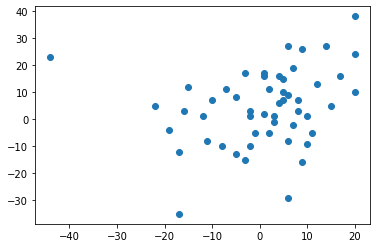

In [178]:
data_comb = D[D['regular_score_diff'].isnull()==False]
plt.scatter(x=data_comb['result_score_diff'],y=data_comb['regular_score_diff'])

In [166]:
tourney_result

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1403,61,1277,51,N,0
2249,2019,152,1438,63,1120,62,N,0


In [12]:
#根据季后赛对阵赛程 生成数据 也就是输入模型的X+y
def generate_dataset(raw_data,Regular_stat):
    raw_data['ID']=raw_data.apply(lambda x:GetID(x['Season'],x['WTeamID'],x['LTeamID']),axis =1)
    raw_data['result']=raw_data.apply(lambda x:function(x['WTeamID'],x['LTeamID']),axis =1)
    raw_data['result_score_diff']=raw_data.apply(lambda x:function_score(x['WScore'],x['LScore'],
                                                                         x['result']),axis =1)
    raw_data['Team1']=raw_data['ID'].map(lambda x: int(x[5:9]))
    raw_data['Team2']=raw_data['ID'].map(lambda x: int(x[10:14]))
    raw_data.drop(['WScore','LScore','WTeamID','LTeamID'],axis=1, inplace=True)
    raw_data.reset_index()
    raw_data1 = pd.merge(raw_data,Regular_stat,left_on=['Season','Team1'],\
                                  right_on=['Season','TeamID'],how='left')
    raw_data1.drop(['TeamID','GameCount','WCount','LCount','ID','Season','result','result_score_diff','Team1','Team2','index'],axis=1, 
                   inplace=True)
    raw_data2 = pd.merge(raw_data,Regular_stat,left_on=['Season','Team2'],\
                                  right_on=['Season','TeamID'],how='left')
    raw_data2.drop(['TeamID','GameCount','WCount','LCount','ID','Season','result','result_score_diff','Team1','Team2','index'],axis=1, 
                   inplace=True)
    #print(raw_data2)
    raw_data_diff = raw_data1-raw_data2
    raw_data1 = rename_data(raw_data1,'1')
    raw_data2 = rename_data(raw_data2,'2')
    raw_data_diff = rename_data(raw_data_diff,'diff')
    raw_data_final = pd.concat([raw_data,raw_data1, raw_data2,raw_data_diff], axis=1)
    raw_data_final.drop(['index'],axis=1, inplace=True)
    return raw_data_final
def function(a,b):
    if a>b:
        return 0
    return 1
def function_score(a,b,c):
    if c == 1:
        return a-b
    return b-a
def GetID(y,a,b):
    if a>b:
        return str(y)+'_'+str(b)+'_'+str(a)
    return str(y)+'_'+str(a)+'_'+str(b)
def rename_data(dframe,string):
    for index, row in dframe.iteritems():
        dframe.rename(columns={index:index+'_'+string}, inplace=True)
    return dframe

In [13]:
#找两个对常规赛的交手记录，返回总分差和胜率（低index赢高index）
def get_regular_season_record(Team1,Team2,year,Regular_SeasonDetail):
    LowWin = Regular_SeasonDetail[(Regular_SeasonDetail['Season']==year)&
                                  (Regular_SeasonDetail['WTeamID']==Team1)&(Regular_SeasonDetail['LTeamID']==Team2)]
    HighWin = Regular_SeasonDetail[(Regular_SeasonDetail['Season']==year)&
                                   (Regular_SeasonDetail['LTeamID']==Team1)&(Regular_SeasonDetail['WTeamID']==Team2)]
    if LowWin['WScore'].count()+HighWin['WScore'].count()==0:
        return None,None
    Low_sumScore = sum(LowWin['WScore']) + sum(HighWin['LScore'])
    High_sumScore = sum(LowWin['LScore']) + sum(HighWin['WScore'])
    regular_score_diff = Low_sumScore-High_sumScore
    winning_percentage = LowWin['WScore'].count()/(LowWin['WScore'].count()+HighWin['WScore'].count()+0.0000000001)
    return regular_score_diff, round(winning_percentage,2)

In [14]:
def get_split_yeardata(year,data):
    y = data['result']
    y2 = data['result_score_diff']
    y_test = y[data['Season']>=year].reset_index()
    y_train = y[data['Season']<year].reset_index()
    y2_train = y2[data['Season']>=year].reset_index()
    y2_test = y2[data['Season']>=year].reset_index()
    X = data.drop(['ID','Season','result','result_score_diff','Team1','Team2'],axis=1)
    X_test = X[data['Season']>=year].reset_index()
    X_train = X[data['Season']<year].reset_index()
    X_train.drop(['index'],axis=1,inplace=True)
    y_train.drop(['index'],axis=1,inplace=True)
    X_test.drop(['index'],axis=1,inplace=True)
    y_test.drop(['index'],axis=1,inplace=True)
    return X_train,X_test,y_train,y_test,y2_train,y2_test

In [18]:
D.to_csv('Data.csv',index=False)

In [82]:
X_train,X_test,y_train,y_test,y2_train,y2_test=get_split_yeardata(2015,D)
X_train

,PW_1,Score_1,OppoScore_1,OR_1,DR_1,OppoOR_1,OppoDR_1,TS_1,OppoTS_1,Seed_1,rank_min_1,rank_max_1,rank_mean_1,rank_std_1,PW_2,Score_2,OppoScore_2,OR_2,DR_2,OppoOR_2,OppoDR_2,TS_2,OppoTS_2,Seed_2,rank_min_2,rank_max_2,rank_mean_2,rank_std_2,PW_diff,Score_diff,OppoScore_diff,OR_diff,DR_diff,OppoOR_diff,OppoDR_diff,TS_diff,OppoTS_diff,Seed_diff,rank_min_diff,rank_max_diff,rank_mean_diff,rank_std_diff,regular_score_diff,regular_PW
0,0.600000,38.400000,36.526667,6.706667,13.226667,6.393333,11.720000,0.530748,0.494015,16.0,147.0,293.0,239.281250,27.267178,0.448276,35.598098,39.889417,6.202140,11.561237,6.983353,11.602854,0.529601,0.541155,16.0,184.0,293.0,240.343750,30.734670,0.151724,2.801902,-3.362751,0.504526,1.665430,-0.590020,0.117146,0.001147,-0.047140,0.0,-37.0,0.0,-1.062500,-3.467492,NaN,NaN
1,0.892857,69.602041,55.876276,12.036990,22.716837,10.524235,18.321429,0.545902,0.468522,1.0,1.0,10.0,2.676471,1.854080,0.655172,37.973841,33.917955,7.135553,14.381688,5.092747,11.573127,0.519148,0.483050,16.0,101.0,187.0,153.125000,21.501313,0.237685,31.628200,21.958321,4.901437,8.335148,5.431488,6.748301,0.026754,-0.014528,-15.0,-100.0,-177.0,-150.448529,-19.647233,NaN,NaN
2,0.620690,40.908442,35.726516,7.290131,12.620690,5.853746,10.558859,0.559734,0.525981,10.0,22.0,52.0,36.000000,7.071068,0.793103,50.205707,42.505351,9.318668,17.763377,8.112961,15.512485,0.520424,0.480485,7.0,11.0,32.0,21.705882,4.502722,-0.172414,-9.297265,-6.778835,-2.028537,-5.142687,-2.259215,-4.953627,0.039310,0.045496,3.0,11.0,20.0,14.294118,2.568345,NaN,NaN
3,0.793103,55.166468,48.708680,6.940547,15.953627,8.414982,12.156956,0.610802,0.544100,11.0,12.0,97.0,45.687500,14.693509,0.878788,63.324151,49.671258,8.458219,18.627181,8.572084,16.707989,0.577834,0.505349,6.0,8.0,51.0,20.735294,7.739348,-0.085684,-8.157682,-0.962578,-1.517672,-2.673554,-0.157102,-4.551033,0.032969,0.038751,5.0,4.0,46.0,24.952206,6.954161,NaN,NaN
4,0.724138,45.248514,40.575505,6.501784,15.134364,6.482759,13.439952,0.547409,0.500102,8.0,25.0,62.0,36.406250,10.159564,0.600000,38.306667,34.740000,5.000000,11.633333,5.433333,10.960000,0.550187,0.531816,9.0,23.0,81.0,50.312500,10.696510,0.124138,6.941847,5.835505,1.501784,3.501031,1.049425,2.479952,-0.002778,-0.031714,-1.0,2.0,-19.0,-13.906250,-0.536946,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.764706,47.581315,39.593426,6.406574,16.477509,8.205882,13.835640,0.556677,0.475265,7.0,10.0,38.0,22.907692,4.920376,0.764706,50.411765,41.482699,7.164360,17.095156,6.425606,13.865052,0.558548,0.499181,4.0,5.0,24.0,12.092308,4.137191,0.000000,-2.830450,-1.889273,-0.757785,-0.617647,1.780277,-0.029412,-0.001870,-0.023916,3.0,5.0,14.0,10.815385,0.783185,NaN,NaN
776,0.705882,45.131488,37.865052,8.534602,15.762976,6.624567,11.413495,0.551327,0.488819,8.0,8.0,37.0,21.904762,5.821856,0.757576,48.460055,40.416896,5.501377,14.802571,5.564738,13.353535,0.573253,0.506542,2.0,4.0,26.0,12.015385,4.273802,-0.051693,-3.328567,-2.551844,3.033225,0.960405,1.059829,-1.940041,-0.021927,-0.017723,6.0,4.0,11.0,9.889377,1.548054,NaN,NaN
777,0.764706,47.581315,39.593426,6.406574,16.477509,8.205882,13.835640,0.556677,0.475265,7.0,10.0,38.0,22.907692,4.920376,0.941176,63.538062,51.314879,10.548443,21.420415,8.885813,18.673010,0.552162,0.481946,1.0,1.0,10.0,2.092308,1.388829,-0.176471,-15.956747,-11.721453,-4.141869,-4.942907,-0.679931,-4.837370,0.004515,-0.006681,6.0,9.0,28.0,20.815385,3.531547,1.0,1.0
778,0.705882,45.131488,37.865052,8.534602,15.762976,6.624567,11.413495,0.551327,0.488819,8.0,8.0,37.0,21.904762,5.821856,0.787879,49.797062,41.857668,5.807163,16.672176,6.516070,14.748393,0.565080,0.502697,2.0,1.0,17.0,9.369231,3.044304,-0.081996,-4.665574,-3.992616,2.727440,-0.909201,0.108498,-3.334898,-0.013753,-0.013878,6.0,7.0,20.0,12.535531,2.777552,NaN,NaN


In [83]:
y_test

,result
0,1
1,0
2,0
3,0
4,1
...,...
330,1
331,0
332,0
333,0


In [21]:
def fill_submission(submission_df,Regular_stat):
    test_df=pd.DataFrame()
    test_df['Season'] = submission_df['ID'].map(lambda x: int(x[:4]))
    test_df['Team1'] = submission_df['ID'].map(lambda x: int(x[5:9]))
    test_df['Team2'] = submission_df['ID'].map(lambda x: int(x[10:14]))
    raw_data1 = pd.merge(test_df,Regular_stat,left_on=['Season','Team1'],\
                                  right_on=['Season','TeamID'],how='left')
    raw_data1.drop(['TeamID','GameCount','WCount','LCount','Season','Team1','Team2'],axis=1, 
                   inplace=True)
    raw_data2 = pd.merge(test_df,Regular_stat,left_on=['Season','Team2'],\
                                  right_on=['Season','TeamID'],how='left')
    raw_data2.drop(['TeamID','GameCount','WCount','LCount','Season','Team1','Team2'],axis=1, 
                   inplace=True)
    #print(raw_data2)
    raw_data_diff = raw_data1-raw_data2
    raw_data1 = rename_data(raw_data1,'1')
    raw_data2 = rename_data(raw_data2,'2')
    raw_data_diff = rename_data(raw_data_diff,'diff')
    raw_data_final = pd.concat([submission_df,raw_data1, raw_data2,raw_data_diff], axis=1)
    raw_data_final.drop(['Pred','ID'],axis=1, inplace=True)
    test_df['ID'] = submission_df['ID']
    return raw_data_final,test_df

In [22]:
submission_df = pd.read_csv('/Users/ggq/Downloads/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
#t = submission_df
sub_data,test_df = fill_submission(submission_df,Regular_Team_stat_seed)


In [23]:
#test_df是submission 没啥用
test_df=pd.DataFrame()
test_df['Season'] = submission_df['ID'].map(lambda x: int(x[:4]))
test_df['Team1'] = submission_df['ID'].map(lambda x: int(x[5:9]))
test_df['Team2'] = submission_df['ID'].map(lambda x: int(x[10:14]))

In [24]:
test_df['diff']=test_df.apply(lambda x:get_regular_season_record(x['Team1'],x['Team2'],x['Season'],
                                                                 Regular_SeasonDetail)[0],axis =1)
test_df['PW']=test_df.apply(lambda x:get_regular_season_record(x['Team1'],x['Team2'],x['Season'],
                                                                 Regular_SeasonDetail)[1],axis =1)

In [27]:
def Construct_Ground_Truth(test_df,D):
    GT = pd.merge(test_df,D[['ID','result']],left_on=['ID'],\
                                  right_on=['ID'],how='left')
    return GT

In [ ]:
#sub = Construct_Ground_Truth(test_df,D)

In [146]:
# sub.fillna(0.5,inplace = True)
# sub.drop(['Season','Team1','Team2'],axis =1 ,inplace = True)
# sub.rename(columns={'result':'Pred'}, inplace=True)
# sub.to_csv('GT.csv', index=False)

In [29]:
test_df

,Season,Team1,Team2,diff,PW
0,2015,1107,1112,NaN,NaN
1,2015,1107,1116,NaN,NaN
2,2015,1107,1124,NaN,NaN
3,2015,1107,1125,NaN,NaN
4,2015,1107,1129,NaN,NaN
...,...,...,...,...,...
11385,2019,1449,1459,NaN,NaN
11386,2019,1449,1463,NaN,NaN
11387,2019,1458,1459,NaN,NaN
11388,2019,1458,1463,NaN,NaN


# LightGBM+XGBoost

In [224]:
import time

y_preds_xgb = np.zeros(test_df.shape[0])

params_xgb = {'colsample_bytree': 0.4,                 
              'learning_rate': 0.0003,
              'max_depth': 3,
              'subsample': 0.5,
              'objective':'binary:logistic',
              'eval_metric':'logloss',
              'min_child_weight':6,
              'colsample_bylevel':0.7,
              'reg_alpha':0.0007, 
              'reg_lambda':0.001,
              'gamma':0.25,
              'n_estimators':50
              }
starttime = time.clock()
X_train,X_test,y_train,y_test,y2_train,y2_test=get_split_yeardata(2015,D)
train_set = xgb.DMatrix(X_train, y_train)
val_set = xgb.DMatrix(X_test, y_test)
clf = xgb.train(params_xgb, train_set,num_boost_round=100000, evals=[(train_set, 'train'), (val_set, 'val')], 
                early_stopping_rounds=100, verbose_eval=100) 
y_preds_xgb = clf.predict(val_set)
endtime = time.clock()
print (endtime - starttime)

[0]	train-logloss:0.693067	val-logloss:0.693065
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.684771	val-logloss:0.685822


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[200]	train-logloss:0.6769	val-logloss:0.679068
[300]	train-logloss:0.669387	val-logloss:0.672555
[400]	train-logloss:0.662271	val-logloss:0.666268
[500]	train-logloss:0.655468	val-logloss:0.660495
[600]	train-logloss:0.648984	val-logloss:0.654906
[700]	train-logloss:0.642821	val-logloss:0.649733
[800]	train-logloss:0.636857	val-logloss:0.644717
[900]	train-logloss:0.63123	val-logloss:0.639943
[1000]	train-logloss:0.625839	val-logloss:0.635505
[1100]	train-logloss:0.620625	val-logloss:0.631099
[1200]	train-logloss:0.615688	val-logloss:0.626994
[1300]	train-logloss:0.610959	val-logloss:0.623189
[1400]	train-logloss:0.606424	val-logloss:0.61958
[1500]	train-logloss:0.602071	val-logloss:0.616013
[1600]	train-logloss:0.597917	val-logloss:0.612723
[1700]	train-logloss:0.59393	val-logloss:0.609563
[1800]	train-logloss:0.590084	val-logloss:0.606535
[1900]	train-logloss:0.586344	val-logloss:0.603658
[2000]	train-logloss:0.582766	val-logloss:0.600879
[2100]	train-logloss:0.579334	val-logloss:0.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [86]:
#y_preds_lgb = np.zeros(test_df.shape[0])
params_lgb = {'num_leaves': 127,
          'min_data_in_leaf': 10,
          'objective': 'binary',
          'max_depth': 7,
          'learning_rate': 0.001,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'logloss',
          "verbosity": 3,
          'random_state': 42,
         }
starttime = time.clock()
X_train,X_test,y_train,y_test,y2_train,y2_test=get_split_yeardata(2015,D)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

clf = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid])
y_preds_lgb = clf.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


In [90]:
fi_df = clf.plot_feature_importance()

AttributeError: 'Booster' object has no attribute 'plot_feature_importance'

0.5466178341464278


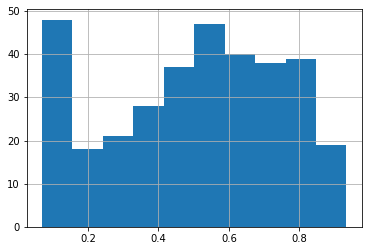

In [87]:
from sklearn.metrics import log_loss
d = pd.DataFrame()
d['P'] = y_preds_lgb
d['P'].hist()
print(log_loss(y_test,y_preds_lgb))

0.545092120944564


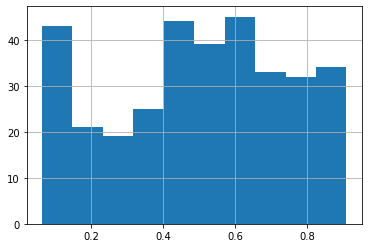

In [225]:
d = pd.DataFrame()
d['P'] = y_preds_xgb
d['P'].hist()
print(log_loss(y_test,y_preds_xgb))

In [311]:
# plot
xgb.plot_importance(clf)

ValueError: tree must be Booster, XGBModel or dict instance

In [162]:
submission_df.to_csv('submission.csv', index=False)

In [91]:
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

In [105]:
kfold= StratifiedKFold(n_splits=5,shuffle=True,random_state=3)

In [108]:
def modelfit(alg,X_train,y_train,cv_folds=None,early_stopping_rounds=100):
    xgb_param=alg.get_xgb_params()
    #xgb_param['num_class']=2
    xgtrain=xgb.DMatrix(X_train,label=y_train)
    cvresult=xgb.cv(xgb_param,xgtrain,num_boost_round=alg.get_params()['n_estimators'],
                    folds=cv_folds,metrics='logloss',early_stopping_rounds=early_stopping_rounds)
    cvresult.to_csv('1_nestimators.csv',index_label='n_estimators')
    n_estimators=cvresult.shape[0]
    alg.set_params(n_estimators=n_estimators)
    alg.fit(X_train,y_train,eval_metric='logloss')

In [205]:
# params_xgb = {'colsample_bytree': 0.8,                 
#               'learning_rate': 0.0003,
#               'max_depth': 31,
#               'subsample': 1,
#               'objective':'binary:logistic',
#               'eval_metric':'logloss',
#               'min_child_weight':3,
#               'gamma':0.25,
#               'n_estimators':50
#               }
xgbl= XGBClassifier(
    learning_rate=0.0003,
    n_estimators=10000,
    max_depth=3,
    min_child_weight=6,
    gamma=0.25,
    reg_alpha=0.0007, 
    reg_lambda=0.001,
    subsample=0.5,
    colsample_bytree=0.4,
    colsample_bylevel=0.7,
    objective='binary:logistic',
    eval_metric='logloss',)
modelfit(xgbl,X_train,y_train,cv_folds=kfold)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


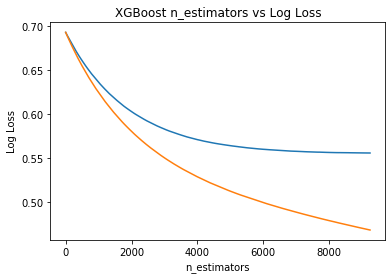

In [206]:
cvresult=pd.read_csv('1_nestimators.csv')
test_means=cvresult['test-logloss-mean']
test_stds=cvresult['test-logloss-std']
train_means=cvresult['train-logloss-mean']
train_stds=cvresult['train-logloss-std']
x_axis=range(0,cvresult.shape[0])
pyplot.errorbar(x_axis,test_means,label='Test')#yerr=test_stds,
pyplot.errorbar(x_axis,train_means,label='Train')#yerr=train_stds,
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.show()

In [209]:
cvresult

,n_estimators,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0,0.693061,0.000009,0.693077,0.000010
1,1,0.692972,0.000014,0.692998,0.000025
2,2,0.692884,0.000020,0.692925,0.000026
3,3,0.692800,0.000027,0.692851,0.000029
4,4,0.692716,0.000035,0.692777,0.000038
...,...,...,...,...,...
9240,9240,0.468628,0.008993,0.556060,0.038440
9241,9241,0.468619,0.008994,0.556055,0.038439
9242,9242,0.468610,0.008996,0.556054,0.038448
9243,9243,0.468604,0.008996,0.556053,0.038446


In [130]:
max_depth=range(1,40,5)
min_child_weight=range(1,6)
param_test1_1=dict(max_depth=list(max_depth),min_child_weight=list(min_child_weight))
param_test1_1

{'max_depth': [1, 6, 11, 16, 21, 26, 31, 36],
 'min_child_weight': [1, 2, 3, 4, 5]}

In [131]:
xgb1_1 = XGBClassifier(learning_rate=0.0003,n_estimators=8000,max_depth=31,min_child_weight=3,
                       gamma=0.25,subsample=0.3,colsample_bytree=0.8,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch1_1=GridSearchCV(xgb1_1,param_grid=param_test1_1,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch1_1.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=31, min_child_weight=3,
                                     missing=None, n_estimators=8000, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.3, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 6, 11, 16, 21, 26, 31, 36],
                   

In [134]:
gsearch1_1.best_params_,gsearch1_1.best_score_

({'max_depth': 6, 'min_child_weight': 5}, -0.5600976590067148)

Best: -0.560098 using {'max_depth': 6, 'min_child_weight': 5}


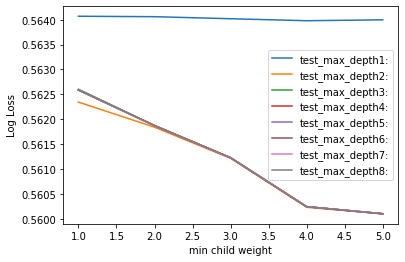

In [137]:
print("Best: %f using %s"%(gsearch1_1.best_score_,gsearch1_1.best_params_))
test_means=gsearch1_1.cv_results_['mean_test_score']
test_stds=gsearch1_1.cv_results_['std_test_score']
train_means=gsearch1_1.cv_results_['mean_train_score']
train_stds=gsearch1_1.cv_results_['std_train_score']
#pd.DataFrame(gsearch2_1.cv_results_).to_scv('C:/my_preds_maxdepth')
test_scores=np.array(test_means).reshape(len(max_depth),len(min_child_weight))
train_scores=np.array(train_means).reshape(len(max_depth),len(min_child_weight))
for i,value in enumerate(max_depth):
    pyplot.plot(min_child_weight,-test_scores[i],label='test_max_depth'+str(i+1)+':')

pyplot.legend()
pyplot.xlabel('min child weight')
pyplot.ylabel('Log Loss')
pyplot.savefig('max_depth_vs_min_child_weght.png')

In [142]:
#gsearch1_1.cv_results_

In [139]:
#第二轮调参
max_depth=range(4,15,2)
min_child_weight=range(5,9)
param_test1_2=dict(max_depth=list(max_depth),min_child_weight=list(min_child_weight))
param_test1_2

{'max_depth': [4, 6, 8, 10, 12, 14], 'min_child_weight': [5, 6, 7, 8]}

In [140]:
xgb1_2 = XGBClassifier(learning_rate=0.0003,n_estimators=8000,max_depth=31,min_child_weight=3,
                       gamma=0.25,subsample=0.3,colsample_bytree=0.8,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch1_2=GridSearchCV(xgb1_2,param_grid=param_test1_2,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch1_2.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=31, min_child_weight=3,
                                     missing=None, n_estimators=8000, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.3, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10, 12, 14],
                         'mi

In [141]:
gsearch1_2.best_params_,gsearch1_2.best_score_

({'max_depth': 4, 'min_child_weight': 6}, -0.5600955922061052)

Best: -0.560096 using {'max_depth': 4, 'min_child_weight': 6}


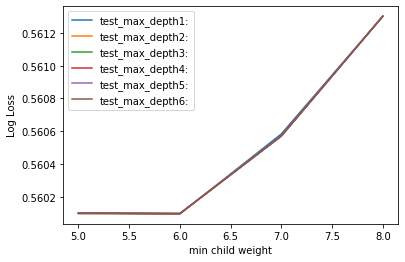

In [143]:
print("Best: %f using %s"%(gsearch1_2.best_score_,gsearch1_2.best_params_))
test_means=gsearch1_2.cv_results_['mean_test_score']
test_stds=gsearch1_2.cv_results_['std_test_score']
train_means=gsearch1_2.cv_results_['mean_train_score']
train_stds=gsearch1_2.cv_results_['std_train_score']
#pd.DataFrame(gsearch2_1.cv_results_).to_scv('C:/my_preds_maxdepth')
test_scores=np.array(test_means).reshape(len(max_depth),len(min_child_weight))
train_scores=np.array(train_means).reshape(len(max_depth),len(min_child_weight))
for i,value in enumerate(max_depth):
    pyplot.plot(min_child_weight,-test_scores[i],label='test_max_depth'+str(i+1)+':')

pyplot.legend()
pyplot.xlabel('min child weight')
pyplot.ylabel('Log Loss')
pyplot.savefig('max_depth_vs_min_child_weght.png')

In [145]:
#第三轮调参
max_depth=range(3,7)
min_child_weight=range(3,7)
param_test1_3=dict(max_depth=list(max_depth),min_child_weight=list(min_child_weight))
param_test1_3

{'max_depth': [3, 4, 5, 6], 'min_child_weight': [3, 4, 5, 6]}

In [151]:
xgb1_3 = XGBClassifier(learning_rate=0.0003,n_estimators=9000,max_depth=31,min_child_weight=3,
                       gamma=0.25,subsample=0.3,colsample_bytree=0.8,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch1_3=GridSearchCV(xgb1_3,param_grid=param_test1_3,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch1_3.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=31, min_child_weight=3,
                                     missing=None, n_estimators=9000, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.3, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'min_child_w

Best: -0.559177 using {'max_depth': 3, 'min_child_weight': 6}


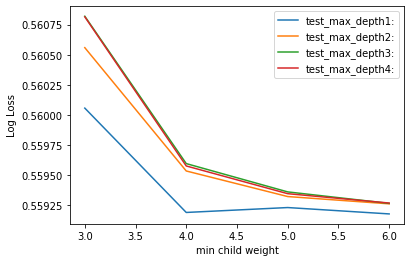

In [152]:
print("Best: %f using %s"%(gsearch1_3.best_score_,gsearch1_3.best_params_))
test_means=gsearch1_3.cv_results_['mean_test_score']
test_stds=gsearch1_3.cv_results_['std_test_score']
train_means=gsearch1_3.cv_results_['mean_train_score']
train_stds=gsearch1_3.cv_results_['std_train_score']
#pd.DataFrame(gsearch2_1.cv_results_).to_scv('C:/my_preds_maxdepth')
test_scores=np.array(test_means).reshape(len(max_depth),len(min_child_weight))
train_scores=np.array(train_means).reshape(len(max_depth),len(min_child_weight))
for i,value in enumerate(max_depth):
    pyplot.plot(min_child_weight,-test_scores[i],label='test_max_depth'+str(i+1)+':')

pyplot.legend()
pyplot.xlabel('min child weight')
pyplot.ylabel('Log Loss')
pyplot.savefig('max_depth_vs_min_child_weght.png')

In [150]:
#最佳max_depth:3,min_child_weight:6

In [159]:
subsample=[i/10.0 for i in range(3,9)]
colsample_bytree=[i/10.0 for i in range(6,10)]
param_test2_1=dict(subsample=list(subsample),colsample_bytree=list(colsample_bytree))
param_test2_1

{'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}

In [163]:
xgb2_1 = XGBClassifier(learning_rate=0.0003,n_estimators=9400,max_depth=3,min_child_weight=6,
                       gamma=0.25,subsample=0.3,colsample_bytree=0.8,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch2_1=GridSearchCV(xgb2_1,param_grid=param_test2_1,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch2_1.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=9400, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.3, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                       

Best: -0.558358 using {'colsample_bytree': 0.6, 'subsample': 0.4}


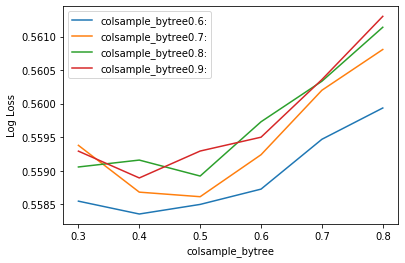

In [176]:
print("Best: %f using %s"%(gsearch2_1.best_score_,gsearch2_1.best_params_))
test_means=gsearch2_1.cv_results_['mean_test_score']
test_stds=gsearch2_1.cv_results_['std_test_score']
train_means=gsearch2_1.cv_results_['mean_train_score']
train_stds=gsearch2_1.cv_results_['std_train_score']
test_scores=np.array(test_means).reshape(len(colsample_bytree),len(subsample))
train_scores=np.array(train_means).reshape(len(colsample_bytree),len(subsample))
for i,value in enumerate(colsample_bytree):
    pyplot.plot(subsample,-test_scores[i],label='colsample_bytree'+str(colsample_bytree[i])+':')

pyplot.legend()
pyplot.xlabel('colsample_bytree')
pyplot.ylabel('Log Loss')
pyplot.savefig('subsample_vs_colsample_bytree.png')

In [172]:
gsearch2_1.best_params_,gsearch2_1.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.4}, -0.5583577353793842)

In [173]:
gsearch2_1.cv_results_

{'mean_fit_time': array([15.59628658, 17.20173469, 18.90864835, 19.98338656, 20.63823934,
        21.74744654, 17.69786615, 19.05204945, 20.24692979, 21.34177194,
        22.56659336, 23.26805177, 18.5190774 , 20.60083361, 22.20445175,
        23.19137206, 24.09622431, 25.00240469, 19.2644412 , 21.68672996,
        23.45494447, 24.72374296, 24.71292644, 22.51741424]),
 'std_fit_time': array([0.03166902, 0.0775501 , 0.28967929, 0.12900062, 0.22901973,
        0.13614556, 0.10703817, 0.24530314, 0.04344504, 0.282415  ,
        0.0515628 , 0.12330184, 0.09219505, 0.07683763, 0.07830762,
        0.0507564 , 0.08653172, 0.16280507, 0.02866759, 0.08700403,
        0.07447821, 0.14485341, 0.4250742 , 1.36880493]),
 'mean_score_time': array([0.11876254, 0.11957059, 0.09397793, 0.0801641 , 0.08138218,
        0.1050437 , 0.08792405, 0.07358041, 0.08399725, 0.07518005,
        0.07275758, 0.07063704, 0.07152247, 0.075103  , 0.07541628,
        0.07439585, 0.06978998, 0.0710144 , 0.07210622, 0.07

In [183]:
subsample=[i/10.0 for i in range(1,6)]
colsample_bytree=[i/10.0 for i in range(4,7)]
param_test2_2=dict(subsample=list(subsample),colsample_bytree=list(colsample_bytree))
param_test2_2

{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5], 'colsample_bytree': [0.4, 0.5, 0.6]}

In [184]:
xgb2_2 = XGBClassifier(learning_rate=0.0003,n_estimators=9400,max_depth=3,min_child_weight=6,
                       gamma=0.25,subsample=0.3,colsample_bytree=0.8,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch2_2=GridSearchCV(xgb2_2,param_grid=param_test2_2,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch2_2.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=9400, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.3, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'su

Best: -0.557644 using {'colsample_bytree': 0.4, 'subsample': 0.5}


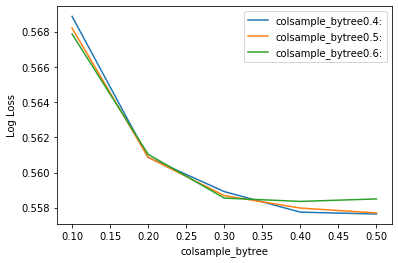

In [185]:
print("Best: %f using %s"%(gsearch2_2.best_score_,gsearch2_2.best_params_))
test_means=gsearch2_2.cv_results_['mean_test_score']
test_stds=gsearch2_2.cv_results_['std_test_score']
train_means=gsearch2_2.cv_results_['mean_train_score']
train_stds=gsearch2_2.cv_results_['std_train_score']
test_scores=np.array(test_means).reshape(len(colsample_bytree),len(subsample))
train_scores=np.array(train_means).reshape(len(colsample_bytree),len(subsample))
for i,value in enumerate(colsample_bytree):
    pyplot.plot(subsample,-test_scores[i],label='colsample_bytree'+str(colsample_bytree[i])+':')

pyplot.legend()
pyplot.xlabel('colsample_bytree')
pyplot.ylabel('Log Loss')
pyplot.savefig('subsample_vs_colsample_bytree.png')

In [189]:
#正则化参数
reg_alpha=[0.01,0.1,1,0]
reg_lambda=[0.5,1,2]
param_test3_1=dict(reg_alpha=list(reg_alpha),reg_lambda=list(reg_lambda))
param_test3_1

{'reg_alpha': [0.01, 0.1, 1, 0], 'reg_lambda': [0.5, 1, 2]}

In [190]:
xgb3_1 = XGBClassifier(learning_rate=0.0003,n_estimators=9400,max_depth=3,min_child_weight=6,
                       gamma=0.25,subsample=0.5,colsample_bytree=0.4,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch3_1=GridSearchCV(xgb3_1,param_grid=param_test3_1,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch3_1.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.4, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=9400, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.5, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'reg_alpha': [0.01, 0.1, 1, 0],
                         'reg_lam

Best: -0.557136 using {'reg_alpha': 0.01, 'reg_lambda': 0.5}


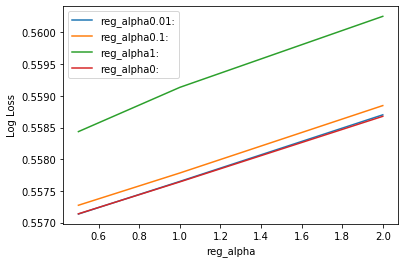

In [191]:
print("Best: %f using %s"%(gsearch3_1.best_score_,gsearch3_1.best_params_))
test_means=gsearch3_1.cv_results_['mean_test_score']
test_stds=gsearch3_1.cv_results_['std_test_score']
train_means=gsearch3_1.cv_results_['mean_train_score']
train_stds=gsearch3_1.cv_results_['std_train_score']
test_scores=np.array(test_means).reshape(len(reg_alpha),len(reg_lambda))
train_scores=np.array(train_means).reshape(len(reg_alpha),len(reg_lambda))
for i,value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda,-test_scores[i],label='reg_alpha'+str(reg_alpha[i])+':')

pyplot.legend()
pyplot.xlabel('reg_alpha')
pyplot.ylabel('Log Loss')
pyplot.savefig('reg_lambda_vs_reg_alpha.png')

In [192]:
reg_alpha=[0.001,0.005,0.01,0.05]
reg_lambda=[0.1,0.3,0.5,0.7]
param_test3_2=dict(reg_alpha=list(reg_alpha),reg_lambda=list(reg_lambda))
param_test3_2

{'reg_alpha': [0.001, 0.005, 0.01, 0.05], 'reg_lambda': [0.1, 0.3, 0.5, 0.7]}

In [193]:
xgb3_2 = XGBClassifier(learning_rate=0.0003,n_estimators=9400,max_depth=3,min_child_weight=6,
                       gamma=0.25,subsample=0.5,colsample_bytree=0.4,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch3_2=GridSearchCV(xgb3_2,param_grid=param_test3_2,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch3_2.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.4, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=9400, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.5, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'reg_alpha': [0.001, 0.005, 0.01, 0.05],
                        

Best: -0.556656 using {'reg_alpha': 0.001, 'reg_lambda': 0.1}


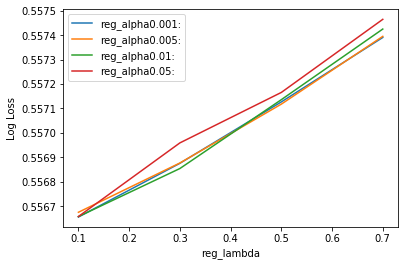

In [196]:
print("Best: %f using %s"%(gsearch3_2.best_score_,gsearch3_2.best_params_))
test_means=gsearch3_2.cv_results_['mean_test_score']
test_stds=gsearch3_2.cv_results_['std_test_score']
train_means=gsearch3_2.cv_results_['mean_train_score']
train_stds=gsearch3_2.cv_results_['std_train_score']
test_scores=np.array(test_means).reshape(len(reg_alpha),len(reg_lambda))
train_scores=np.array(train_means).reshape(len(reg_alpha),len(reg_lambda))
for i,value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda,-test_scores[i],label='reg_alpha'+str(reg_alpha[i])+':')

pyplot.legend()
pyplot.xlabel('reg_lambda')
pyplot.ylabel('Log Loss')
pyplot.savefig('reg_lambda_vs_reg_alpha.png')

In [199]:
reg_alpha=[0.0005,0.0007,0.001,0.002]
reg_lambda=[0.001,0.05,0.07,0.1]
param_test3_3=dict(reg_alpha=list(reg_alpha),reg_lambda=list(reg_lambda))
param_test3_3

{'reg_alpha': [0.0005, 0.0007, 0.001, 0.002],
 'reg_lambda': [0.001, 0.05, 0.07, 0.1]}

In [200]:
xgb3_3 = XGBClassifier(learning_rate=0.0003,n_estimators=9400,max_depth=3,min_child_weight=6,
                       gamma=0.25,subsample=0.5,colsample_bytree=0.4,colsample_bylevel=0.7,
                      objective='binary:logistic',seed=3)
gsearch3_3=GridSearchCV(xgb3_3,param_grid=param_test3_3,scoring='neg_log_loss',n_jobs=-1,cv=kfold,return_train_score=True)
gsearch3_3.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.4, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=9400, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=3, silent=None,
                                     subsample=0.5, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'reg_alpha': [0.0005, 0.0007, 0.001, 0.002],
                    

In [201]:
def draw_param(gsearch,param1,param2,str_param1,str_param2):
    print("Best: %f using %s"%(gsearch.best_score_,gsearch.best_params_))
    test_means=gsearch.cv_results_['mean_test_score']
    test_stds=gsearch.cv_results_['std_test_score']
    train_means=gsearch.cv_results_['mean_train_score']
    train_stds=gsearch.cv_results_['std_train_score']
    test_scores=np.array(test_means).reshape(len(param1),len(param2))
    train_scores=np.array(train_means).reshape(len(param1),len(param2))
    for i,value in enumerate(param1):
        pyplot.plot(param2,-test_scores[i],label=str_param1+str(param1[i])+':')

    pyplot.legend()
    pyplot.xlabel(str_param2)
    pyplot.ylabel('Log Loss')
    pyplot.savefig(str_param1+'_vs_'+str_param2+'.png')

Best: -0.556610 using {'reg_alpha': 0.0007, 'reg_lambda': 0.001}


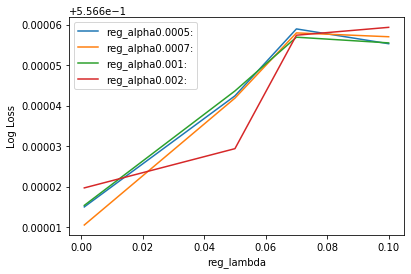

In [202]:
draw_param(gsearch3_3,reg_alpha,reg_lambda,'reg_alpha','reg_lambda')

Best: -0.556610 using {'reg_alpha': 0.0007, 'reg_lambda': 0.001}


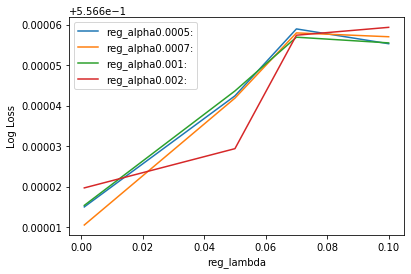

In [203]:
print("Best: %f using %s"%(gsearch3_3.best_score_,gsearch3_3.best_params_))
test_means=gsearch3_3.cv_results_['mean_test_score']
test_stds=gsearch3_3.cv_results_['std_test_score']
train_means=gsearch3_3.cv_results_['mean_train_score']
train_stds=gsearch3_3.cv_results_['std_train_score']
test_scores=np.array(test_means).reshape(len(reg_alpha),len(reg_lambda))
train_scores=np.array(train_means).reshape(len(reg_alpha),len(reg_lambda))
for i,value in enumerate(reg_alpha):
    pyplot.plot(reg_lambda,-test_scores[i],label='reg_alpha'+str(reg_alpha[i])+':')

pyplot.legend()
pyplot.xlabel('reg_lambda')
pyplot.ylabel('Log Loss')
pyplot.savefig('reg_lambda_vs_reg_alpha.png')

In [221]:
gamma=[0.24,0.25,0.26]
param_test4_1=dict(gamma=list(gamma))
param_test4_1

{'gamma': [0.24, 0.25, 0.26]}

In [222]:
xgb4_1 = XGBClassifier(learning_rate=0.0003,n_estimators=9400,max_depth=3,min_child_weight=6,
                       gamma=0.25,subsample=0.5,colsample_bytree=0.4,colsample_bylevel=0.7,
                      objective='binary:logistic',reg_alpha=0.0007, reg_lambda=0.001,seed=3)
gsearch4_1=GridSearchCV(xgb4_1,param_grid=param_test4_1,scoring='neg_log_loss',n_jobs=-1,\
                        cv=kfold,return_train_score=True)
gsearch4_1.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.7, colsample_bynode=1,
                                     colsample_bytree=0.4, gamma=0.25,
                                     learning_rate=0.0003, max_delta_step=0,
                                     max_depth=3, min_child_weight=6,
                                     missing=None, n_estimators=9400, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0.0007,
                                     reg_lambda=0.001, scale_pos_weight=1,
                                     seed=3, silent=None, subsample=0.5,
                                     verbosity=1),
             iid='warn', n_jobs=-1, param_grid={'gamma': [0.24, 0.25, 0.26]},
  

In [223]:
print("Best: %f using %s"%(gsearch4_1.best_score_,gsearch4_1.best_params_))

Best: -0.556609 using {'gamma': 0.26}


In [228]:
xgb_final = XGBClassifier(learning_rate=0.0003,n_estimators=9400,max_depth=3,min_child_weight=6,
                       gamma=0.25,subsample=0.5,colsample_bytree=0.4,colsample_bylevel=0.7,
                      objective='binary:logistic',reg_alpha=0.0007, reg_lambda=0.001,seed=3)
xgb_final.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.25,
              learning_rate=0.0003, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=None, n_estimators=9400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.0007, reg_lambda=0.001, scale_pos_weight=1, seed=3,
              silent=None, subsample=0.5, verbosity=1)

In [231]:
xgb_final.feature_importances_

array([0.02178215, 0.01983019, 0.01715911, 0.01639687, 0.02231897,
       0.01806166, 0.01702939, 0.01665827, 0.01993168, 0.03221522,
       0.04520216, 0.03063739, 0.03724736, 0.03122668, 0.01465536,
       0.01449178, 0.01557374, 0.01851245, 0.01734974, 0.01514636,
       0.01599917, 0.01537312, 0.01557032, 0.0224536 , 0.02183681,
       0.02295754, 0.02199888, 0.02166925, 0.01859143, 0.01933476,
       0.01581436, 0.01995332, 0.01744531, 0.01885546, 0.01729566,
       0.01358594, 0.01579869, 0.04628799, 0.04791474, 0.05095846,
       0.04985003, 0.04902864, 0.        , 0.        ], dtype=float32)

# lightGBM调参

In [305]:
def modelfit_lgb(params,alg,X_train,y_train,early_stopping_rounds=100,cv_folds=None):
    lgbm_params = params.copy()
    lgbmtrain = lgb.Dataset(X_train,label=y_train)
    cv_result = lgb.cv(
        lgbm_params,lgbmtrain,num_boost_round=9000,metrics='logloss',folds=cv_folds,
        show_stdv=True,seed=0,stratified = True, shuffle=True,verbose_eval=50,
        early_stopping_rounds = early_stopping_rounds
    )
    print('best n_estimators:',len(cv_result['multi_logloss-mean']))
    print('best cv_score:',cv_result['multi_logloss-mean'][-1])
    alg.set_params(n_estimators = len(cv_result['multi_logloss-mean']))
    alg.fit(X_train,y_train)

In [306]:
params = {'boosting_type':'gbdt',
          'objective': 'binary',
          'silent':False,
          'learning_rate':0.0003,
          'num_leaves':127,
          'max_depth':5,
          'max_bin':127,
          'subsample_for_bin':50000,
          'subsample':0.8,
          'subsample_freq':1,
          'colsample_bytree':0.8,
          'reg_alpha':1,
          'reg_lambda':0,
          'metric': 'logloss',
          'min_data_in_leaf': 10
          #'min_split_gain':0.0,
          #'min_child_weight':1,
          #'min_child_samples':20,
          #'scale_pos_weight':1
         }
lgbml = lgb.sklearn.LGBMClassifier(n_estimators=10000,seed=0,**params)
#modelfit(params,lgbml,X_train,y_train)

In [323]:
#y_preds_lgb = np.zeros(test_df.shape[0])
params_lgb = {'num_leaves': 100,
          'min_data_in_leaf': 10,
          'objective': 'binary',
          'max_depth': 7,
          'subsample':0.8,
          'colsample_bytree':0.8,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'logloss',
          'random_state': 42
         }
#X_train,X_test,y_train,y_test,y2_train,y2_test=get_split_yeardata(2015,D)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

# clf = lgb.train(params_lgb, dtrain, 2000, valid_sets = [dtrain, dvalid],verbose_eval=100)
# y_preds_lgb = clf.predict(X_test)

cv_results = lgb.cv(
    params_lgb, dtrain, num_boost_round=1000, nfold=5, stratified=True, shuffle=False, metrics='logloss',
    verbose_eval=50, show_stdv=True, seed=0)

In [346]:
params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 30,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": -1,                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2019, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

folds = KFold(n_splits=5, shuffle=True, random_state=2019)
prob_oof = np.zeros((X_train.shape[0], ))
test_pred_prob = np.zeros((y_test.shape[0], ))


## train and predict
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    print("fold {}".format(fold_ + 1))
    train = X_train.iloc[trn_idx]
    t_label = y_train.iloc[trn_idx]
    trn_data = lgb.Dataset(train, label=t_label)
    test = X_train.iloc[val_idx]
    te_label = y_train.iloc[val_idx]
    val_data = lgb.Dataset(test, label=te_label)


    clf = lgb.train(params,
                    trn_data,
                    2000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=20,
                    early_stopping_rounds=60)
    prob_oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    #fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    test_pred_prob += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

threshold = 0.5
for pred in test_pred_prob:
    result = 1 if pred > threshold else 0

fold 1
Training until validation scores don't improve for 60 rounds
[20]	training's binary_logloss: 0.545307	training's auc: 0.898463	valid_1's binary_logloss: 0.62179	valid_1's auc: 0.72941
[40]	training's binary_logloss: 0.466872	training's auc: 0.921516	valid_1's binary_logloss: 0.605848	valid_1's auc: 0.731054
[60]	training's binary_logloss: 0.415256	training's auc: 0.939292	valid_1's binary_logloss: 0.596516	valid_1's auc: 0.746671
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.653447	training's auc: 0.874773	valid_1's binary_logloss: 0.667934	valid_1's auc: 0.752425
fold 2
Training until validation scores don't improve for 60 rounds
[20]	training's binary_logloss: 0.54943	training's auc: 0.899978	valid_1's binary_logloss: 0.612039	valid_1's auc: 0.755713
[40]	training's binary_logloss: 0.47354	training's auc: 0.918115	valid_1's binary_logloss: 0.590592	valid_1's auc: 0.748973
[60]	training's binary_logloss: 0.421501	training's auc: 0.93622	valid_1's binary_lo

In [341]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    print("fold {} ti {} vi{}".format(fold_ + 1,trn_idx, val_idx))
    print(y_train.iloc[trn_idx])

fold 1 ti [  0   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19  21
  22  23  24  25  26  27  29  30  31  32  35  36  37  38  40  44  45  47
  48  50  51  52  53  54  55  58  59  61  63  64  65  66  67  69  70  71
  72  73  75  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98 100 103 104 105 106 108 109 110 113 114 115 116
 117 119 122 123 124 125 126 128 129 130 132 133 134 135 136 137 138 142
 144 146 147 148 149 150 151 153 154 155 156 157 159 160 161 163 164 165
 167 168 169 171 172 173 174 176 177 178 179 182 183 184 185 187 188 189
 190 191 192 193 194 195 196 197 198 199 201 202 203 205 206 207 208 209
 211 212 213 214 215 216 217 219 221 222 223 224 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 244 245 247 248 251 253 254 255
 256 257 258 259 260 261 263 264 265 266 267 268 269 270 271 272 273 274
 275 278 280 281 282 283 284 285 286 287 288 289 290 292 294 296 297 299
 301 303 304 305 306 307 309 310 311 312 

In [339]:
y[]

,PW_1,Score_1,OppoScore_1,OR_1,DR_1,OppoOR_1,OppoDR_1,TS_1,OppoTS_1,Seed_1,rank_min_1,rank_max_1,rank_mean_1,rank_std_1,PW_2,Score_2,OppoScore_2,OR_2,DR_2,OppoOR_2,OppoDR_2,TS_2,OppoTS_2,Seed_2,rank_min_2,rank_max_2,rank_mean_2,rank_std_2,PW_diff,Score_diff,OppoScore_diff,OR_diff,DR_diff,OppoOR_diff,OppoDR_diff,TS_diff,OppoTS_diff,Seed_diff,rank_min_diff,rank_max_diff,rank_mean_diff,rank_std_diff,regular_score_diff,regular_PW
0,0.600000,38.400000,36.526667,6.706667,13.226667,6.393333,11.720000,0.530748,0.494015,16.0,147.0,293.0,239.281250,27.267178,0.448276,35.598098,39.889417,6.202140,11.561237,6.983353,11.602854,0.529601,0.541155,16.0,184.0,293.0,240.343750,30.734670,0.151724,2.801902,-3.362751,0.504526,1.665430,-0.590020,0.117146,0.001147,-0.047140,0.0,-37.0,0.0,-1.062500,-3.467492,NaN,NaN
1,0.892857,69.602041,55.876276,12.036990,22.716837,10.524235,18.321429,0.545902,0.468522,1.0,1.0,10.0,2.676471,1.854080,0.655172,37.973841,33.917955,7.135553,14.381688,5.092747,11.573127,0.519148,0.483050,16.0,101.0,187.0,153.125000,21.501313,0.237685,31.628200,21.958321,4.901437,8.335148,5.431488,6.748301,0.026754,-0.014528,-15.0,-100.0,-177.0,-150.448529,-19.647233,NaN,NaN
2,0.620690,40.908442,35.726516,7.290131,12.620690,5.853746,10.558859,0.559734,0.525981,10.0,22.0,52.0,36.000000,7.071068,0.793103,50.205707,42.505351,9.318668,17.763377,8.112961,15.512485,0.520424,0.480485,7.0,11.0,32.0,21.705882,4.502722,-0.172414,-9.297265,-6.778835,-2.028537,-5.142687,-2.259215,-4.953627,0.039310,0.045496,3.0,11.0,20.0,14.294118,2.568345,NaN,NaN
3,0.793103,55.166468,48.708680,6.940547,15.953627,8.414982,12.156956,0.610802,0.544100,11.0,12.0,97.0,45.687500,14.693509,0.878788,63.324151,49.671258,8.458219,18.627181,8.572084,16.707989,0.577834,0.505349,6.0,8.0,51.0,20.735294,7.739348,-0.085684,-8.157682,-0.962578,-1.517672,-2.673554,-0.157102,-4.551033,0.032969,0.038751,5.0,4.0,46.0,24.952206,6.954161,NaN,NaN
4,0.724138,45.248514,40.575505,6.501784,15.134364,6.482759,13.439952,0.547409,0.500102,8.0,25.0,62.0,36.406250,10.159564,0.600000,38.306667,34.740000,5.000000,11.633333,5.433333,10.960000,0.550187,0.531816,9.0,23.0,81.0,50.312500,10.696510,0.124138,6.941847,5.835505,1.501784,3.501031,1.049425,2.479952,-0.002778,-0.031714,-1.0,2.0,-19.0,-13.906250,-0.536946,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.764706,47.581315,39.593426,6.406574,16.477509,8.205882,13.835640,0.556677,0.475265,7.0,10.0,38.0,22.907692,4.920376,0.764706,50.411765,41.482699,7.164360,17.095156,6.425606,13.865052,0.558548,0.499181,4.0,5.0,24.0,12.092308,4.137191,0.000000,-2.830450,-1.889273,-0.757785,-0.617647,1.780277,-0.029412,-0.001870,-0.023916,3.0,5.0,14.0,10.815385,0.783185,NaN,NaN
776,0.705882,45.131488,37.865052,8.534602,15.762976,6.624567,11.413495,0.551327,0.488819,8.0,8.0,37.0,21.904762,5.821856,0.757576,48.460055,40.416896,5.501377,14.802571,5.564738,13.353535,0.573253,0.506542,2.0,4.0,26.0,12.015385,4.273802,-0.051693,-3.328567,-2.551844,3.033225,0.960405,1.059829,-1.940041,-0.021927,-0.017723,6.0,4.0,11.0,9.889377,1.548054,NaN,NaN
777,0.764706,47.581315,39.593426,6.406574,16.477509,8.205882,13.835640,0.556677,0.475265,7.0,10.0,38.0,22.907692,4.920376,0.941176,63.538062,51.314879,10.548443,21.420415,8.885813,18.673010,0.552162,0.481946,1.0,1.0,10.0,2.092308,1.388829,-0.176471,-15.956747,-11.721453,-4.141869,-4.942907,-0.679931,-4.837370,0.004515,-0.006681,6.0,9.0,28.0,20.815385,3.531547,1.0,1.0
778,0.705882,45.131488,37.865052,8.534602,15.762976,6.624567,11.413495,0.551327,0.488819,8.0,8.0,37.0,21.904762,5.821856,0.787879,49.797062,41.857668,5.807163,16.672176,6.516070,14.748393,0.565080,0.502697,2.0,1.0,17.0,9.369231,3.044304,-0.081996,-4.665574,-3.992616,2.727440,-0.909201,0.108498,-3.334898,-0.013753,-0.013878,6.0,7.0,20.0,12.535531,2.777552,NaN,NaN
